In [34]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import f1_score, roc_curve, roc_auc_score, precision_recall_curve

from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
import xgboost as xgb

from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import f_classif,chi2
from sklearn.preprocessing import Binarizer, scale

from sklearn.svm import SVC

import time

In [4]:
names_VI = ["ExG", "ExGR", "CIVE", "VEG", "WI", "NGRDI"]
fpr = [np.array([0]) for i in range(6)]
tpr = [np.array([0]) for i in range(6)]
fpr2 = [np.array([0]) for i in range(6)]
tpr2 = [np.array([0]) for i in range(6)]

In [17]:
VI = [0 for i in range(6)]
for j in range(6):
    VI[j] = np.load("Mini/" + names_VI[j] + ".npy")
GT = np.load("Mini/GT.npy")
print(np.count_nonzero(VI[0]))
print(np.count_nonzero(GT))
print(GT.shape)
print(VI[0].shape)

9437159
6706552
(9437184,)
(9437184,)


In [5]:
NB = np.load(names_VI[5] + "NB.npy")
for j in range(6):
    NBvecless[j] = np.load(names_VI[j] + "NBless.npy")

In [6]:
SVMtemp = np.load("SVM_10.npy")

In [7]:
SVM = np.zeros(SVMtemp.shape[0]*256)
for i in range(SVMtemp.shape[0]):
    for j in range(256):
        SVM[i*256+j] = SVMtemp[i]

In [50]:
print("AUC =", roc_auc_score(GT[::256], SVMtemp))

AUC = 0.825548248088


In [11]:
for j in range(6):
    print(names_VI[j], "AUC =", roc_auc_score(GT, VI[j]))
    fpr[j], tpr[j], _ = roc_curve(GT, VI[j])
#     print(names_VI[j], "AUC nbless=", roc_auc_score(GT, NBvecless[j]))
#     fpr2[j], tpr2[j], _ = roc_curve(GT, NBvecless[j])
    
#print(names_VI[j], "AUC NB =", roc_auc_score(GT, NB))
#fpr3, tpr3, _ = roc_curve(GT, SVM)    

ExG AUC = 0.802886084447
ExGR AUC = 0.812791590312
CIVE AUC = 0.809619316026
VEG AUC = 0.81193907549
WI AUC = 0.748015443113
NGRDI AUC = 0.819970303121


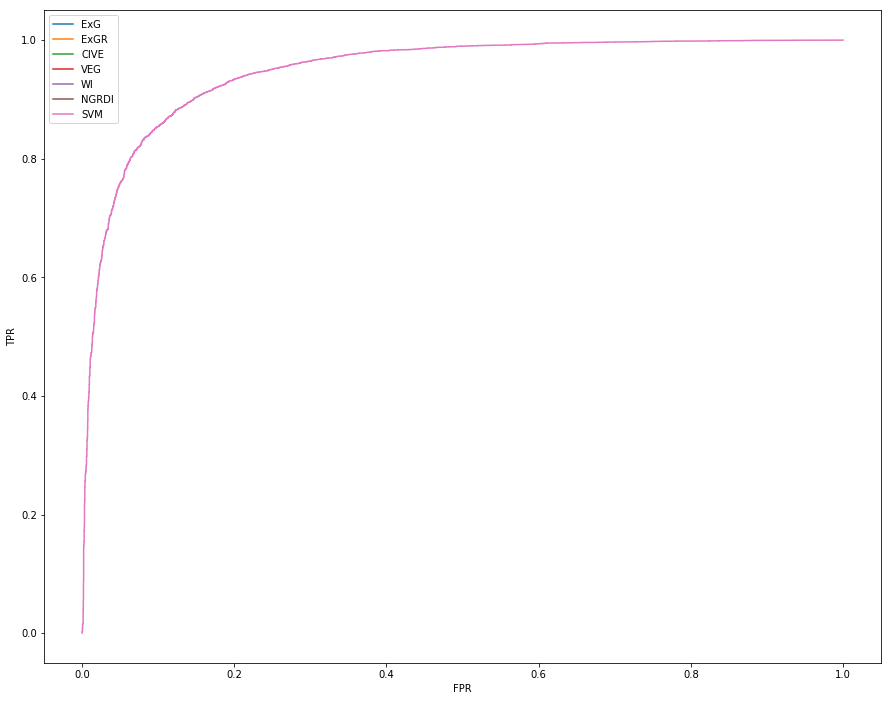

In [49]:
plt.figure(figsize=(15,12))
for j in range(6):
    plt.plot(fpr[j], tpr[j], label = names_VI[j])
    
fpr3, tpr3, _ = roc_curve(y_test, np.load("SVM_100.npy"))
plt.plot(fpr3, tpr3, label = "SVM")
    
plt.legend()
plt.xlabel('FPR')
plt.ylabel('TPR')


In [28]:
def toMat(I):
    R = np.zeros((int(I.shape[0]/256), 256))
    for i in range(R.shape[0]):
        R[i,:] = I[i*256:(i+1)*256]
    return R

In [22]:
newVI = toMat(VI[0])


In [24]:
print(np.count_nonzero(VI[0]))
print(newVI.shape)
print(newVI[0,2] == VI[0][2])

9437159
(147456, 64)
True


In [29]:
X = np.zeros((int(GT.shape[0]/256), 256 * 6), dtype = float)


In [30]:
for i in range(6):
    X[:,i*256:(i+1)*256] = toMat(VI[i])

In [20]:
for i in range(6):
    X[:,i] = VI[i][::256]
X[:,6] = SVMtemp

In [31]:
print(X.shape)

(36864, 1536)


In [ ]:
for i in range(X.shape[0]):
    for j in range(6):
        X[i, j*256] = VI[j][i*256]

In [10]:
for j in range(6):
    X[:, j] = VI[j]

X[:, 6] = NB
X[:, 7] = SVM
del(VI)
print(X.shape)

ValueError: could not broadcast input array from shape (9437184) into shape (36864)

In [57]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)


In [58]:
X = np.column_stack((X, X_pca[:,0]))
X = np.column_stack((X, X_pca[:,1]))

In [19]:

# for j in range(6):
#     X = np.column_stack((X, NBvecless[j]))
X[:,0] = NBvecless[0]    
X[:,2] = NBvecless[2]
X[:,3] = NBvecless[3]
X[:,4] = NBvecless[4]

# X[:,0] = NBvecless[0]    
# X[:,1] = NBvecless[1]
# X[:,2] = NBvecless[2]
# X[:,3] = NBvecless[3]
# X[:,4] = NBvecless[5]


print(X.shape)

(9437184, 10)


In [ ]:
sel = f_classif(X, GT)

In [ ]:
print(sel[0])

In [ ]:
print(sorted(range(15), key = lambda x : sel[0][x], reverse = True))

In [ ]:
p = 75 

X_bin = Binarizer().fit_transform(scale(X))
selectChi2 = SelectPercentile(chi2, percentile=p).fit(X_bin, GT)
selectF_classif = SelectPercentile(f_classif, percentile=p).fit(X, GT)

chi2_selected = selectChi2.get_support(True)
f_classif_selected = selectF_classif.get_support(True)

selected = list(set(chi2_selected).intersection(f_classif_selected))
print(selected)

In [20]:
##  TREINO NORMAL
#X_train, X_test, y_train, y_test = train_test_split(X, GT, random_state=1301, stratify=GT, test_size=0.4)
X_train, X_test = np.split(X, [512*512*25], axis = 0)
y_train, y_test = np.split(GT, [512*512*25])

print(X_train.shape)
print(y_train.shape)


(6553600, 10)
(6553600,)


In [45]:
X = np.column_stack((X, GT[::256]))

In [46]:
print(X.shape)
print(np.count_nonzero(X))

(36864, 1537)
56649139


In [47]:
np.random.shuffle(X)

In [48]:
GT = X[:,-1]
X = X[:,:-1]
print(X.shape)
print(np.count_nonzero(X))
print(GT.shape)
print(np.count_nonzero(GT))

(36864, 1536)
56622953
(36864,)
26186


In [59]:
## Treino para SVM
X_train, X_test = np.split(X, [2*512*22], axis = 0)
y_train, y_test = np.split(GT, [2*512*22])

print(X_test.shape)
print(y_test.shape)
print(X_train.shape)
print(y_train.shape)
print(X_test)
print( y_test)
print(X_train)
print(y_train)
print(np.count_nonzero(y_test))
print(np.count_nonzero(y_train))



(14336, 1539)
(14336,)
(22528, 1539)
(22528,)
[[ 0.31767365  0.47034532  0.52039385 ...,  0.95984453  3.17389868
   1.45912327]
 [ 0.32577485  0.30323949  0.2918545  ...,  0.97881336  5.79805728
  -0.578528  ]
 [ 0.41753343  0.36052287  0.31032658 ...,  0.91200671  1.13045187
   0.83726185]
 ..., 
 [ 0.04956784  0.05189634  0.06331588 ...,  0.8075269   0.91048167
  -3.55619116]
 [ 0.43419269  0.35234997  0.27890512 ...,  0.95187872  2.04663617
   2.81461314]
 [ 0.4985227   0.50643611  0.52523017 ...,  0.98477356  5.94625292
   0.70643742]]
[ 0.  1.  1. ...,  1.  0.  1.]
[[ 0.09284858  0.09451183  0.08764023 ...,  0.13172761 -6.26893331
   0.1386751 ]
 [ 0.11764706  0.12034375  0.12916604 ...,  0.41600065 -3.81859276
   0.4280215 ]
 [ 0.31250435  0.23941901  0.16798985 ...,  0.92676527  2.35455121
  -0.8025443 ]
 ..., 
 [ 0.18702707  0.18453433  0.17798343 ...,  0.31115624 -4.08805981
  -0.52617009]
 [ 0.245869    0.29297608  0.31677023 ...,  0.77568216 -0.70824738
  -0.42970891]
 [ 0.2

In [41]:
np.count_nonzero(X_train)

51200

In [50]:
clf = SVC(probability=True)
start = time.process_time()
clf.fit(X_train[::10], y_train[::10])
print("Fitted", time.process_time() - start)
predict = clf.predict_proba(X_test)[:,-1]
print("SVM AUC =", roc_auc_score(y_test, predict))


Fitted 34.14980972800004
SVM AUC = 0.841297777567


In [51]:
predict = clf.predict_proba(X)[:,-1]
print("SVM AUC =", roc_auc_score(GT, predict))

SVM AUC = 0.841104029701


In [43]:
predict = clf.predict_proba(X_train)[:,-1]
print("SVM AUC =", roc_auc_score(y_train, predict))

SVM AUC = 0.812665138083


In [52]:
np.save("SVM_10", predict)

In [48]:
print("SVM AUC =", roc_auc_score(y_test, np.load("SVM_100.npy")))

SVM AUC = 0.948612794658


In [53]:
X = np.column_stack((X, predict))

In [56]:
X_test[::100].shape

(144, 1537)

In [27]:
predict = 0
best_pred = 0
melhor_auc = 0
melhor_clf = 0

estart = 20
estep = 0

dstart = 2
dstep = 1

for i in range(1):
	print('Depth: ', dstart+i*dstep)
	for j in range(5):
		clf = RFC(	class_weight = "balanced",
					n_estimators = estart+i*estep,
					#oob_score = True,
					#warm_start = True,
					max_depth = dstart+i*dstep,
					#max_leaf_nodes = 4,
					n_jobs = 3
					)


		clf.fit(X_train, y_train)
		print("FITTED")
		#print('acerto = {:.2}'.format(clf.score(X_test, y_test)))

		predict = clf.predict_proba(X_test)[:,1]
		auc = roc_auc_score(y_test, predict)
		print('Overall AUC:', auc)

		if auc > melhor_auc:
			melhor_auc = auc
			best_pred = predict
			melhor_clf = clf

	print("\n")

Depth:  2
FITTED


IndexError: index 1 is out of bounds for axis 1 with size 1

In [ ]:
plt.figure(figsize=(15,12))
for j in range(6):
    plt.plot(fpr[j], tpr[j], label = names_VI[j])

FPR, TPR, _ = roc_curve(y_test, best_pred)
plt.plot(FPR, TPR, label = "Combined")
    
plt.legend()
plt.xlabel('FPR')
plt.ylabel('TPR')

print(melhor_auc)

In [ ]:
print(melhor_clf.feature_importances_)

[0]	validation_0-auc:0.784853	validation_1-auc:0.78302
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.81099	validation_1-auc:0.810773
[2]	validation_0-auc:0.816636	validation_1-auc:0.815676
[3]	validation_0-auc:0.823376	validation_1-auc:0.822754
[4]	validation_0-auc:0.847066	validation_1-auc:0.846075
[5]	validation_0-auc:0.852618	validation_1-auc:0.851653
[6]	validation_0-auc:0.858245	validation_1-auc:0.85692
[7]	validation_0-auc:0.859429	validation_1-auc:0.857916
[8]	validation_0-auc:0.860876	validation_1-auc:0.85763
[9]	validation_0-auc:0.862722	validation_1-auc:0.859628
[10]	validation_0-auc:0.863175	validation_1-auc:0.860017
[11]	validation_0-auc:0.863867	validation_1-auc:0.860424
[12]	validation_0-auc:0.864424	validation_1-auc:0.861041
[13]	validation_0-auc:0.863916	validation_1-auc:0.860584
[14]	validation_0-auc:0.863864	validation_1-auc:0.860424
[1

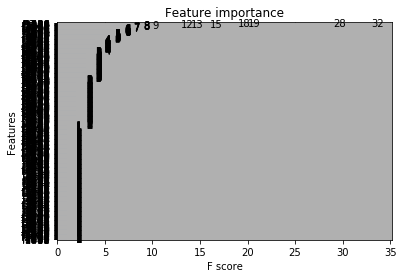

In [61]:
ratio = float(np.sum(GT == 1)) / np.sum(GT==0)

clf = xgb.XGBClassifier(missing=9999999999,
                max_depth = 2,
                n_estimators=500,
                learning_rate=0.1, 
                nthread=3,
                subsample=1.0,
                colsample_bytree=5/9,
                #min_child_weight = 3,
                scale_pos_weight = ratio,
                reg_alpha=0.03,
                seed=1301)
                
clf.fit(X_train, y_train, early_stopping_rounds=20, eval_metric="auc",
        eval_set=[(X_train, y_train), (X_test, y_test)])
        
print('Overall AUC:', roc_auc_score(y_test, clf.predict_proba(X_test, ntree_limit=clf.best_iteration)[:,1]))
xgb.plot_importance(clf)

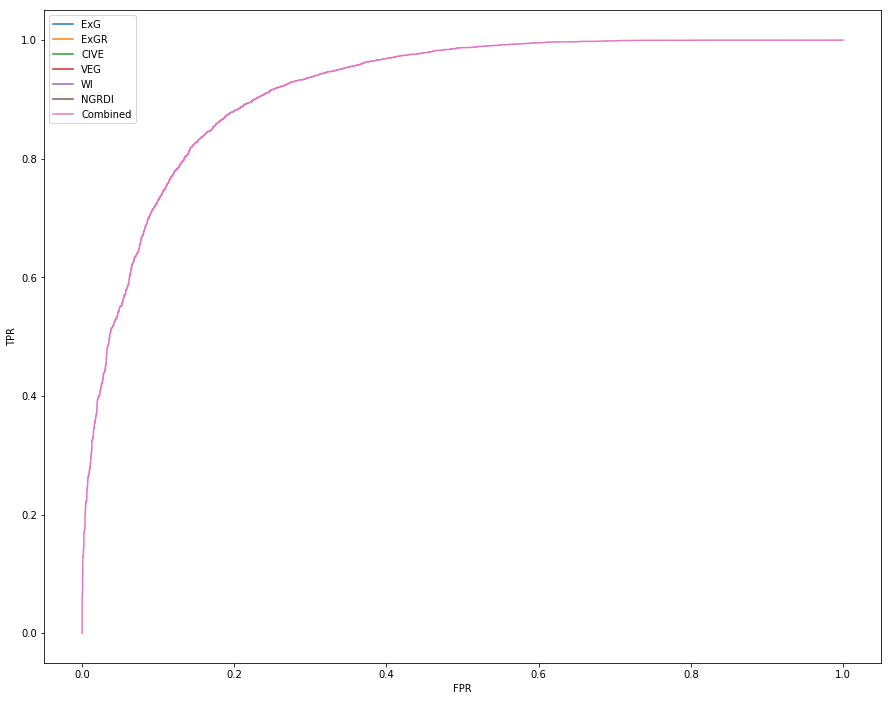

In [62]:
best_pred = clf.predict_proba(X_test, ntree_limit=clf.best_iteration)[:,1]
plt.figure(figsize=(15,12))
for j in range(6):
    plt.plot(fpr[j], tpr[j], label = names_VI[j])

FPR, TPR, _ = roc_curve(y_test, best_pred)
plt.plot(FPR, TPR, label = "Combined")
    
plt.legend()
plt.xlabel('FPR')
plt.ylabel('TPR')


In [ ]:
xgb.plot_importance(clf)

In [ ]:
print(TPR)
print(1- FPR)

In [63]:
i_max = max(range(len(TPR)), key = lambda x : TPR[x] + 1 - FPR[x])

In [64]:
print((TPR[i_max] + 1 - FPR[i_max])/2)

0.841855193684


In [65]:
clf.feature_importances_

array([ 0.0013369 ,  0.00066845,  0.00066845, ...,  0.01871658,
        0.00601604,  0.01002674], dtype=float32)

In [67]:
fi = sorted(range(len(clf.feature_importances_)), key = lambda x : clf.feature_importances_[x], reverse = True)[:10]
print(fi)

[1280, 1536, 1024, 768, 1538, 1025, 1281, 1537, 769, 926]
